## Get started
### Imports

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm
from os.path import exists, dirname
import os, sys
import numpy as np
import seaborn as sns
import json
path = os.path.dirname((os.path.abspath(''))) + '/dreem_nap'
print(path)
sys.path.append(path)
from dreem_nap import *
from dreem_nap import Study
import yaml

/Users/ymdt/src/dreem_nap/dreem_nap


ModuleNotFoundError: No module named 'dreem_nap.study'

### Configuration
- Load config file and check what's in it
- Configurate the Notebook

In [ ]:
with open('config.yml', 'r') as ymlfile:
    cfg = yaml.safe_load(ymlfile)
for k,v in cfg.items():
    print(k,(30-len(k))*'_',v)

mpl.rcParams['figure.dpi'] = cfg['mpl_rcParams_figure_dpi'] # the highest the resolution, the slowest the plotting
mpl.rcParams["figure.figsize"] = cfg['mpl_rcParams_figure_figsize'] # (width, height) in inches

### Load data
Create and load dataframe of a single study as a demo

In [ ]:
from dreem_nap.study import Study

# Create a study
salt = Study().from_dict({'name': 'salt',
                         'description': 'Change the Na concentration', 
                         'samples': ['A6', 'B6', 'C6', 'D6', 'E6'], 
                         'title': 'Na quantity [M]', 
                         'conditions': [0.15, 0.3, 0.6, 1.0, 1.2]})

# Load data
salt.load_df_from_local_files(path_to_data= cfg['path_to_data'], 
                              min_cov_bases= cfg['min_cov_bases'])

# Show the dataframe
salt.df.head()

/Users/ymdt/src/dreem_nap/dreem_nap/loader.py:83: RuntimeWarning: invalid value encountered in divide
  df['mut_rates'] = df.apply(lambda x: np.divide(x['mut_bases'],x['info_bases']), axis=1)
/Users/ymdt/src/dreem_nap/dreem_nap/loader.py:83: RuntimeWarning: invalid value encountered in divide
  df['mut_rates'] = df.apply(lambda x: np.divide(x['mut_bases'],x['info_bases']), axis=1)
/Users/ymdt/src/dreem_nap/dreem_nap/loader.py:83: RuntimeWarning: invalid value encountered in divide
  df['mut_rates'] = df.apply(lambda x: np.divide(x['mut_bases'],x['info_bases']), axis=1)
/Users/ymdt/src/dreem_nap/dreem_nap/loader.py:83: RuntimeWarning: invalid value encountered in divide
  df['mut_rates'] = df.apply(lambda x: np.divide(x['mut_bases'],x['info_bases']), axis=1)
/Users/ymdt/src/dreem_nap/dreem_nap/loader.py:83: RuntimeWarning: invalid value encountered in divide
  df['mut_rates'] = df.apply(lambda x: np.divide(x['mut_bases'],x['info_bases']), axis=1)
/Users/ymdt/src/dreem_nap/dreem_nap/load

312 constructs found across all samples for study temperature.


<Figure size 2500x700 with 0 Axes>

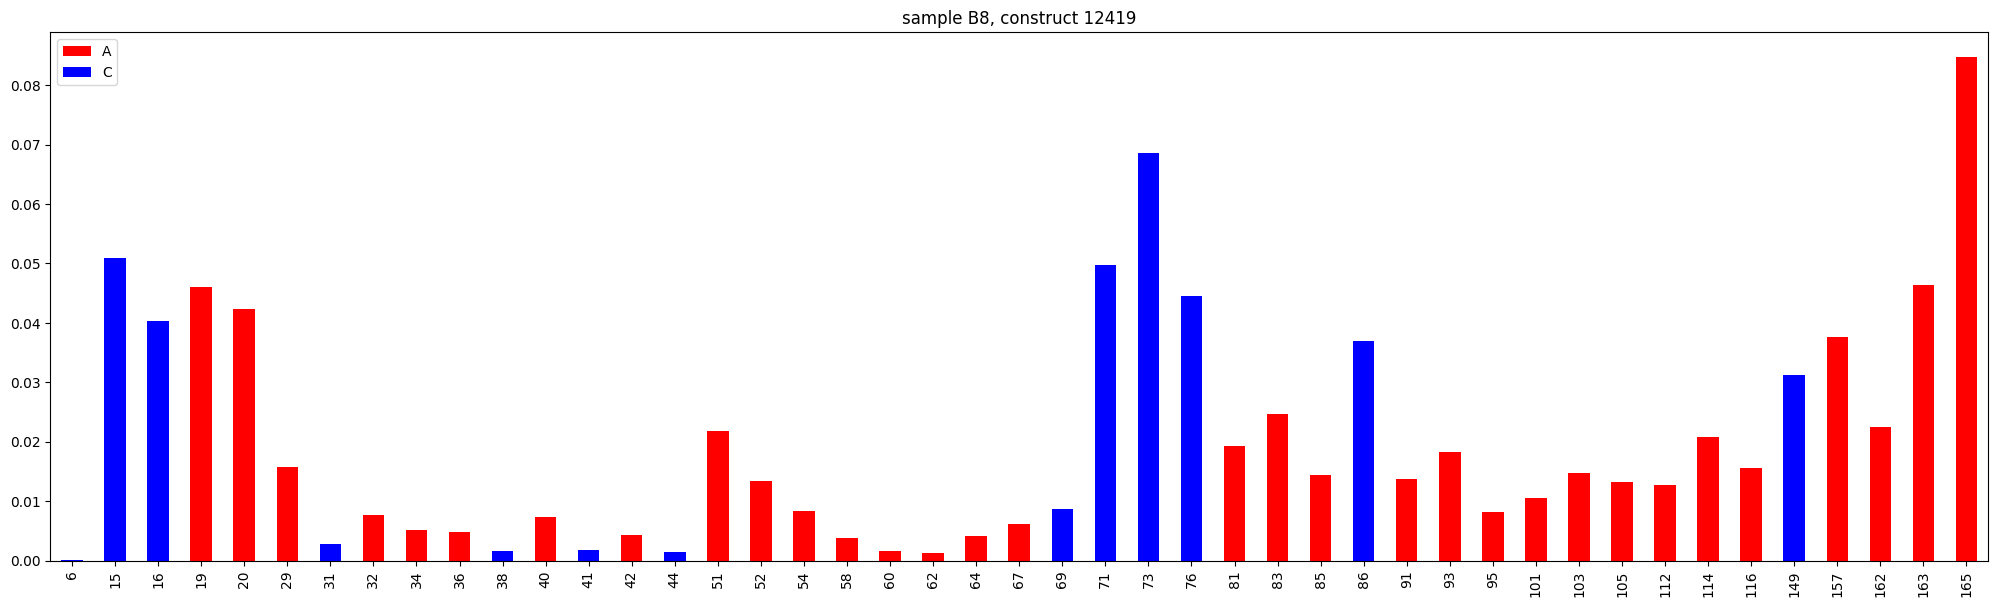

In [2]:
#! usr/bin/env python3

import struct
from zlib import DEF_BUF_SIZE
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm
from os.path import exists, dirname
import os, sys
import numpy as np
import seaborn as sns
import json

path = '/Users/ymdt/src/dreem_nap/'

sys.path.append(path)

from dreem_nap.study import Study, util
import yaml
import pickle


with open(path+'config.yml', 'r') as ymlfile:
    cfg = yaml.safe_load(ymlfile)

mpl.rcParams['figure.dpi'] = cfg['mpl_rcParams_figure_dpi'] # the highest the resolution, the slowest the plotting

####
# SET HYPER PARAMETERS HERE
####

studies = Study.load_studies(cfg['path_to_studies'])
study = Study().from_dict(studies['temperature'].__dict__)
study.load_df_from_local_files(path_to_data= cfg['path_to_data'], min_cov_bases= 100)#cfg['cov_min_bases'])

with open(path+'data/temperature_df.p','rb') as f:
    study.df = pickle.load(f)
    f.close()

study.constructs = study.df['construct'].unique()

samp, construct = 'B8','12419'


study._df['cluster'] = 0

# base_type = ['A','C','G','T']
# base_index = 'roi', 'all', [93,95,96]
# base_paired = True, False or None (=both) # default is None 
# figsize = (25, 7) # custom by plot type

# structure = "structure_ROI"

# deltaG = "deltaG_ens_DMS"
# cluster = 0, 1, 2

# possible indexes
# roi, all, [93,95,96]

#print(dir(study.plot))
study.plot.mut_histogram(samp=samp, construct=construct, \
    base_type=['A','G'], base_index='all', base_paired=True,\
    structure = 'structure', figsize=(25, 7))


In [ ]:




def assert_structure(df, structure):
    assert structure in df.columns, f"Structure {structure} not found"


def assert_deltaG(df, deltaG):
    assert deltaG in df.columns, f"deltaG {deltaG} not found"


def define_index(df, samp, construct, cluster, index):
    if index in ['all','full'] :
        return df.index
    if index == 'roi':
        assert [roi in df.columns for roi in ['ROI_start','ROI_stop']], 'ROI_start and ROI_stop not found'
        return list(range(int(get_series(df, samp, construct, cluster)['ROI_start']), int(get_series(df, samp, construct, cluster)['ROI_stop'])))
    if type(index) in [list,tuple]:
        assert [i in list(range(len(get_series(df, samp, construct, cluster)['sequence']))) for i in index], 'Index out of range'
        return index
    raise ValueError(f"Index {index} not recognized")

def filter_base_paired(df_loc, base_paired):
    # base_type = ['A','C','G','T']
    # base_index = 'roi', 'all', [93,95,96]
    # base_paired = True, False or None (=both) # default is None 

    if base_paired == True:
        df_loc = df_loc[df_loc['paired'] == True]
    elif base_paired == False:
        df_loc = df_loc[df_loc['paired'] == False]
    elif base_paired == None:
        pass
    return df_loc

def filter_index(df_loc, index):
    return df_loc.loc[index]

def filter_base_type(df_loc, base_type):
    df_loc = pd.concat([df_loc[df_loc['base'] == base] for base in base_type], axis=0)
    return df_loc

def filter(df_loc, base_type, index, base_paired):
    df_loc = filter_index(df_loc, index)
    df_loc = filter_base_paired(df_loc, base_paired)
    df_loc = filter_base_type(df_loc, base_type)
    return df_loc

def get_df(df, samp, construct, cols, cluster=0, structure='structure', deltaG='deltaG', base_type = ['A','C','G','T'], index='all', base_paired=None):

    assert_structure(df, structure)
    assert_deltaG(df, deltaG)
    cols = [c for c in cols if not (c.startswith('deltaG') or c.startswith('structure'))]
    cols = cols + [structure, deltaG]

    for col in cols:
        assert col in df.columns, f"Column {col} not found"

    df_loc = get_series(df, samp, construct, cluster)
    for col in [c for c in cols if type(df_loc[c]) in [str]]:
        df_loc[col] = list(df_loc[col])

    df_loc = pd.DataFrame({col: df_loc[col] for col in cols})

    for st in [col for col in cols if 'structure' in col]:
        df_loc['paired'] = [{'.':False,'(':True,')':True}[x] for x in df_loc[st]]
        df_loc = df_loc.drop(columns=st)
    
    df_loc = df_loc.rename(columns={'sequence':'base'})
    
    index = define_index(df_loc, samp, construct, cluster, index)
    df_loc = filter(df_loc, base_type, index, base_paired)
    return df_loc.sort_index()

def get_series(df, samp, construct, cluster):
    assert len(df_out := study.df[(study.df['construct'] == construct)&(study.df['samp'] == samp)&(study.df['cluster'] == cluster)]) <= 1, 'More than one row found'
    assert len(df_out) >= 1, 'No row found'
    return df_out.iloc[0]


class OutputPlot(object):
    def __init__(self, fig, ax, data) -> None:
        self.fig = fig
        self.ax = ax
        self.data = data

from dreem_nap import manipulator

class TestPlotter():
    def __init__(self):
        self.__man = manipulator.Manipulator()

    def mut_histogram(self, samp:str, construct:str, plot_type:str='index', figsize=(35,7), **kwargs)->None:
        """Plot the mutation rate of a specific (sample, construct).

        Args:
            samp: sample of interest.
            construct: construct of interest.
            plot_type: 'index' or 'partition'. 
                - 'index' uses bases numbers as index and the original construct bases as colors.
                - 'partition' uses original sequence bases as index and the partition of mutated bases as colors.
            figsize: figure size.
            **kwargs: 
                - keyword arguments for base_type, index, base_paired.
                - keyword arguments for matplotlib.pyplot
        
        Returns:
            OutputPlot: output plot data:
                - fig: figure object.
                - ax: axis object.
                - data: plotted data.
        """
        fig = plt.figure(figsize=figsize)

        df_use = self.df.set_index(['samp','construct'])
        
        if not plot_type in ['index','partition']:
            raise Exception(f"{plot_type} must be 'index' or 'partition', please check this argument")

        df_hist = pd.DataFrame()
        self.__man

        if plot_type == 'index':  # Plot the mutation rate for each base along the sequence

            mut_per_base = pd.DataFrame({'mut_rates': df_use['mut_rates'].loc[samp, construct]
                                        ,'base':list(df_use['sequence'].loc[samp, construct])})\
                                        .reset_index()\
                                        .set_index(['base', 'index'])
            df_hist.index = mut_per_base.reset_index()['index']

            for base in ['A','C','G','T']:
                df_hist[base] = pd.Series(dtype=float)
                df_hist[base] = mut_per_base.loc[base]

            ax = df_hist.plot.bar(stacked=True, color=['r','b','y','g'],  figsize=figsize)
            plt.title(f"sample {samp}, construct {construct}")

        if plot_type == 'partition': # Plot the partition of mutations for each base along the sequence
            for base in ['A','C','G','T']:
                df_hist[f"mod_bases_{base}"]  = np.array(df_use[f"mod_bases_{base}"].loc[samp, construct][1:])/df_use['info_bases'].loc[samp, construct][1:]

            df_hist.index = list(df_use['sequence'].loc[samp,construct])

            ax = df_hist.plot.bar(stacked=True, color=['r','b','y','g'], figsize=figsize)
        
        [getattr(plt, arg)(kwargs[arg]) for arg in kwargs if hasattr(plt, arg)] 

        return OutputPlot(fig, ax, df_hist)


class TestStudy(Study, TestPlotter):
    

cols = ['mut_bases','cov_bases', 'sequence', 'structure', 'deltaG']
print(get_df(df=study.df, samp=samp, construct=construct, cluster=0, cols=cols, index='all', base_paired=None, base_type=['A','C','G','T'], deltaG='deltaG', structure='structure'))
#df = pd.DataFrame(df_loc[cols].str.split('',1),columns=cols)


## Make plots
Plot this study with different plots. Check out the list of plots in the plot module

### Mutation histogram

In [ ]:
salt.mut_histogram(samp='A6', construct='7695',\
             plot_type='index', figsize=(28,4))

### DeltaG
DeltaG vs mutation rate for all constructs of a sample

In [ ]:
salt.deltaG(samp='A6',bases_type=['A','C'], roi_range='all')  # currently bugged due to DREEM, work in progress

### DeltaG_basewise
Plot the mutation rate of each paired-predicted base of the ROI for each construct of a sample, w.r.t the deltaG estimation

In [ ]:
salt.deltaG_basewise(samp='A6', roi_range=[94,95,96,97])

###  Heatmap
Here a heatmap of the minimum base coverage across all samples. Column can be any column that contains a single scalar value.

In [ ]:
salt.heatmap(column='min_cov_bases') 

### Mutation rate vs 1-base_pairing
Plot a mutation rate histogram, a 1-base_pairing probability histogram, and a scatter plot fitting the mutation rate vs 1-base_pairing. 

In [ ]:
# currently bugged due to DREEM, work in progress
salt.mut_rate_vs_base_non_pairing_prob(samp='A6', construct='7695') # shows the mutation rate vs base non-pairing probability

### Base coverage
Plot the base coverage of a specific (sample, construct)

In [ ]:
salt.base_coverage(samp='A6', construct='9572')

### Base coverage for all constructs
Plot the base-coverage of the worst-covered base of the Region of Interest, for each construct. 

In [ ]:
salt.base_coverage_ROI_for_all_constructs()


In [ ]:
salt.random_9_base_coverage()

In [ ]:
random_9_base_coverage()
sample_coverage_distribution()
valid_construct_per_sample()
sliding_window_r2_gini()
study_base()
study_sample()
base_wise_mut_vs_prob()
correlation_n_samples()


In [ ]:
salt.study_base(construct='9572', structure='full',
                roi_range=[40,63,78,94])

### You can load every study from a file using Study.load_studies()

In [ ]:
studies = Study.load_studies(cfg['path_to_studies'])
for study in studies.values():
    if study.name != 'all_samples':
        study.load_df_from_local_files(path_to_data= cfg['path_to_data'], 
                                   min_cov_bases= cfg['min_cov_bases'])

studies['temperature'].df.head()

### Studies can be called from the dictionary using their name

In [ ]:
studies['temperature'].mut_histogram(studies['temperature'].samples[0], '9572', 'index')

In [ ]:
for study in studies.values():
    if study.name != 'all_samples':
        for s in study.samples:
            for construct in study.constructs:
                study.mut_histogram(s, construct, 'index')
                util.save_fig(f"data/figs/date/mutation histogram/{study.name}/{s}/{construct}.png")
                plt.close()


In [ ]:
class TestStudy(Study):
    def mut_histogram(self, samp:str, construct:str, plot_type:str, figsize=(35,7))->None:
        """Plot the mutation rate of a specific (sample, construct).

        Args:
        plot_type: 'index' or 'partition'. 
            - 'index' uses bases numbers as index and the original construct bases as colors.
            - 'partition' uses original sequence bases as index and the partition of mutated bases as colors.
        samp: sample of interest.
        construct: construct of interest.
        """

        df_use = self.df.set_index(['samp','construct'])
        
        if not plot_type in ['index','partition']:
            raise Exception(f"{plot_type} must be 'index' or 'partition', please check this argument")

        if plot_type == 'index':  # Plot the mutation rate for each base along the sequence

            mut_per_base = pd.DataFrame({'mut_rates': df_use['mut_rates'].loc[samp, construct]
                                        ,'base':list(df_use['sequence'].loc[samp, construct])})\
                                        .reset_index()\
                                        .set_index(['base', 'index'])
            df_hist = pd.DataFrame()
            df_hist.index = mut_per_base.reset_index()['index']

            for base in ['A','C','G','T']:
                df_hist[base] = pd.Series(dtype=float)
                df_hist[base] = mut_per_base.loc[base]

            #df_hist.index = mut_per_base.reset_index()['base']

            ax = df_hist.plot.bar(stacked=True, color=['r','b','y','g'],  figsize=figsize)
            plt.title(f"sample {samp}, construct {construct}")

        if plot_type == 'partition': # Plot the partition of mutations for each base along the sequence
            df_hist = pd.DataFrame()
            for base in ['A','C','G','T']:
                df_hist[f"mod_bases_{base}"]  = np.array(df_use[f"mod_bases_{base}"].loc[samp, construct][1:])/df_use['info_bases'].loc[samp, construct][1:]

            df_hist.index = list(df_use['sequence'].loc[samp,construct])

            ax = df_hist.plot.bar(stacked=True, color=['r','b','y','g'], figsize=figsize)

        return ax


# Load configuration
with open('config.yml', 'r') as ymlfile:
    cfg = yaml.safe_load(ymlfile)
for k,v in cfg.items():
    print(k,(30-len(k))*'_',v)

mpl.rcParams['figure.dpi'] = cfg['mpl_rcParams_figure_dpi'] # the highest the resolution, the slowest the plotting

# Create a study
salt = TestStudy().from_dict({'name': 'salt',
                         'description': 'Change the Na concentration', 
                         'samples': ['A6', 'B6', 'C6', 'D6', 'E6'], 
                         'title': 'Na quantity [M]', 
                         'conditions': [0.15, 0.3, 0.6, 1.0, 1.2]})

# Load data
salt.load_df_from_local_files(path_to_data= cfg['path_to_data'], 
                              min_cov_bases= cfg['min_cov_bases'])

# Show the dataframe
salt.df.head()

In [ ]:
import pickle
from os import listdir

listdir('../data/DEMULTIPLEXED/')

with open(f"../data/DEMULTIPLEXED/A4/mh.p",'rb') as f:
    pick =pickle.load(f)
    print(dir(pick['9572']))


In [ ]:
for s in salt.samples:
    salt.mut_histogram(s, '9572', 'index')